In [5]:
# load and summarize
from pandas import read_csv
from matplotlib import pyplot
# load dataset
data = read_csv('Ozone data/eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
print(data.shape)
# summarize class counts
counts = data.groupby(73).size()

for i in range(len(counts)):
	percent = counts[i] / data.shape[0] * 100
	print('Class=%d, total=%d, percentage=%.3f' % (i, counts[i], percent))
    

(2534, 73)
<bound method NDFrame.head of              1    2    3    4    5    6    7    8    9    10 ...     64  \
0                                                            ...          
1998-01-01  0.8  1.8  2.4  2.1    2  2.1  1.5  1.7  1.9  2.3 ...   0.15   
1998-01-02  2.8  3.2  3.3  2.7  3.3  3.2  2.9  2.8  3.1  3.4 ...   0.48   
1998-01-03  2.9  2.8  2.6  2.1  2.2  2.5  2.5  2.7  2.2  2.5 ...    0.6   
1998-01-04  4.7  3.8  3.7  3.8  2.9  3.1  2.8  2.5  2.4  3.1 ...   0.49   
1998-01-05  2.6  2.1  1.6  1.4  0.9  1.5  1.2  1.4  1.3  1.4 ...      ?   
1998-01-06  3.1  3.5  3.3  2.5  1.6  1.7  1.6  1.6  2.3  1.8 ...   0.09   
1998-01-07  3.7  3.2  3.8  5.1    6    7  6.3  6.4  6.3  5.4 ...   0.84   
1998-01-08  2.2  2.9  3.4  4.2  4.7  4.7  5.3  4.9  5.2    6 ...    0.2   
1998-01-09    1  1.5  1.2  1.2  0.7  0.5  1.2  1.4  1.5  2.1 ...   0.51   
1998-01-10  0.9  0.6  0.5  0.5  0.6  0.4  0.4  0.6  1.3  1.5 ...   0.08   
1998-01-11  1.1  1.7  1.4  1.5  0.9  1.5  1.4  1.6  1.9  1.

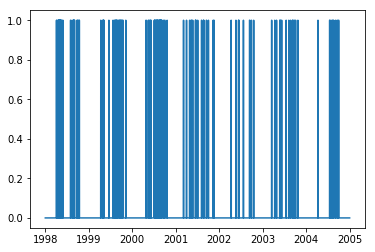

In [8]:
# load and plot output variable
from pandas import read_csv
from matplotlib import pyplot
# load dataset
data = read_csv('Ozone data/eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
# plot the output variable
pyplot.plot(data.index, data.values[:,-1])
pyplot.show()

In [13]:
# load and prepare
from pandas import read_csv
from matplotlib import pyplot
from numpy import array
from numpy import hstack
from numpy import savetxt
# load dataset
data = read_csv('Ozone data/eighthr.data', header=None, index_col=0, parse_dates=True, squeeze=True)
values = data.values
# replace missing observations with 0
values[values=='?'] = 0.0
# frame as supervised learning
supervised = list()
for i in range(len(values) - 1):
	X, y = values[i, :-1], values[i + 1, -1]
	row = hstack((X,y))
	supervised.append(row)
supervised = array(supervised)
# split into train-test
split = 365 * 2
train, test = supervised[:-split,:], supervised[-split:,:]
train, test = train.astype('float32'), test.astype('float32')
print(train.shape, test.shape)
# save prepared datasets
savetxt('Ozone data/train.csv', train, delimiter=',')
savetxt('Ozone data/test.csv', test, delimiter=',')

(1803, 73) (730, 73)


In [15]:
# load datasets
from numpy import loadtxt
train = loadtxt('Ozone data/train.csv', delimiter=',')
test = loadtxt('Ozone data/test.csv', delimiter=',')
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]

In [17]:
# forecast the test dataset
yhat = [naive for _ in range(len(test))]

In [22]:
# evaluate forecast
from sklearn import metrics
testy = test[:, -1]
bs = metrics.brier_score_loss(testy, yhat)
print('Brier Score: %.6f' % bs)

Brier Score: 0.039232


In [23]:
# calculate brier skill score
bs_ref = bs
bss = (bs - bs_ref) / (0 - bs_ref)
print('Brier Skill Score: %.6f' % bss)

Brier Skill Score: -0.000000


In [24]:
# naive prediction method
from sklearn.metrics import brier_score_loss
from numpy import loadtxt
# load datasets
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
print(naive)
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# evaluate forecast
testy = test[:, -1]
bs = brier_score_loss(testy, yhat)
print('Brier Score: %.6f' % bs)
# calculate brier skill score
bs_ref = bs
bss = (bs - bs_ref) / (0 - bs_ref)
print('Brier Skill Score: %.6f' % bss)

0.07265668330560178
Brier Score: 0.039232
Brier Skill Score: -0.000000


In [26]:
# load datasets
train = loadtxt('Ozone data/train.csv', delimiter=',')
test = loadtxt('Ozone data/test.csv', delimiter=',')
# split into inputs/outputs
trainX, trainy, testX, testy = train[:,:-1],train[:,-1],test[:,:-1],test[:,-1]

In [27]:
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# calculate naive bs
bs_ref = brier_score_loss(testy, yhat)

In [28]:
# evaluate a sklearn model
def evaluate_once(bs_ref, template, trainX, trainy, testX, testy):
	# fit model
	model = clone(template)
	model.fit(trainX, trainy)
	# predict probabilities for 0 and 1
	probs = model.predict_proba(testX)
	# keep the probabilities for class=1 only
	yhat = probs[:, 1]
	# calculate brier score
	bs = brier_score_loss(testy, yhat)
	# calculate brier skill score
	bss = (bs - bs_ref) / (0 - bs_ref)
	return bss

In [29]:
# evaluate an sklearn model n times
def evaluate(bs_ref, model, trainX, trainy, testX, testy, n=10):
	scores = [evaluate_once(bs_ref, model, trainX, trainy, testX, testy) for _ in range(n)]
	print('>%s, bss=%.6f' % (type(model), mean(scores)))
	return scores

><class 'sklearn.ensemble.bagging.BaggingClassifier'>, bss=0.069123
><class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, bss=0.111901
><class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, bss=0.119827
><class 'sklearn.ensemble.forest.RandomForestClassifier'>, bss=0.094768


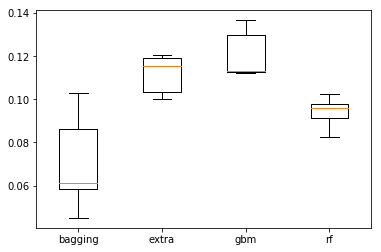

In [33]:
# evaluate ensemble tree methods
from numpy import loadtxt
from numpy import mean
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# evaluate a sklearn model
def evaluate_once(bs_ref, template, trainX, trainy, testX, testy):
	# fit model
	model = clone(template)
	model.fit(trainX, trainy)
	# predict probabilities for 0 and 1
	probs = model.predict_proba(testX)
	# keep the probabilities for class=1 only
	yhat = probs[:, 1]
	# calculate brier score
	bs = brier_score_loss(testy, yhat)
	# calculate brier skill score
	bss = (bs - bs_ref) / (0 - bs_ref)
	return bss

# evaluate an sklearn model n times
def evaluate(bs_ref, model, trainX, trainy, testX, testy, n=10):
	scores = [evaluate_once(bs_ref, model, trainX, trainy, testX, testy) for _ in range(n)]
	print('>%s, bss=%.6f' % (type(model), mean(scores)))
	return scores

# load datasets
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')
# split into inputs/outputs
trainX, trainy, testX, testy = train[:,:-1],train[:,-1],test[:,:-1],test[:,-1]
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# calculate naive bs
bs_ref = brier_score_loss(testy, yhat)
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
n_trees=100
# bagging
model = BaggingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('bagging')
# extra
model = ExtraTreesClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('extra')
# gbm
model = GradientBoostingClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('gbm')
# rf
model = RandomForestClassifier(n_estimators=n_trees)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('rf')
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()

><class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, bss=0.122377
><class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, bss=0.145395
><class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, bss=0.102582
><class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, bss=0.188487


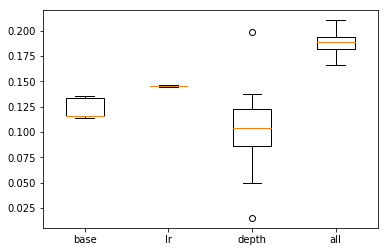

In [34]:
# tune the gbm configuration
from numpy import loadtxt
from numpy import mean
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# evaluate a sklearn model
def evaluate_once(bs_ref, template, trainX, trainy, testX, testy):
	# fit model
	model = clone(template)
	model.fit(trainX, trainy)
	# predict probabilities for 0 and 1
	probs = model.predict_proba(testX)
	# keep the probabilities for class=1 only
	yhat = probs[:, 1]
	# calculate brier score
	bs = brier_score_loss(testy, yhat)
	# calculate brier skill score
	bss = (bs - bs_ref) / (0 - bs_ref)
	return bss

# evaluate an sklearn model n times
def evaluate(bs_ref, model, trainX, trainy, testX, testy, n=10):
	scores = [evaluate_once(bs_ref, model, trainX, trainy, testX, testy) for _ in range(n)]
	print('>%s, bss=%.6f' % (type(model), mean(scores)))
	return scores

# load datasets
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')
# split into inputs/outputs
trainX, trainy, testX, testy = train[:,:-1],train[:,-1],test[:,:-1],test[:,-1]
# estimate naive probabilistic forecast
naive = sum(train[:,-1]) / train.shape[0]
# forecast the test dataset
yhat = [naive for _ in range(len(test))]
# calculate naive bs
bs_ref = brier_score_loss(testy, yhat)
# evaluate a suite of ensemble tree methods
scores, names = list(), list()
# base
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('base')
# learning rate
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=1.0, max_depth=3)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('lr')
# depth
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('depth')
# all
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, subsample=0.7, max_depth=7)
avg_bss = evaluate(bs_ref, model, trainX, trainy, testX, testy)
scores.append(avg_bss)
names.append('all')
# plot results
pyplot.boxplot(scores, labels=names)
pyplot.show()